# <font style="color:blue">Animal Classifier - Part 2: Train an Image Classifier from Scratch</font>
As discussed in the previous notebook, the steps for training Neural Networks are:

- Step 1 - Understand your problem
- Step 2A - Get the data
- Step 2B - Explore & Understand your data
- Step 2C - Create a sample data from the dataset
- Step 3 - Data Preparation
- Step 4 - Train a simple model on sample data and check the pipeline before proceeding to train the full network
- Step 5 - Train on Full Data
- Step 6 - Improve your model

Steps 1 through 4 were already covered in the previous notebook and you can use them in this notebook as well.

In this notebook, steps 5 & 6 will be implemented completely from scratch.



# <font style="color:blue">Step 1: Understand your problem </font>


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My\ Drive/'OpenCV Class 3 Project 1'/

/content/drive/My Drive/OpenCV Class 3 Project 1


### Next two cells are used if GPU is enabled

In [4]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

True
0
Tesla P100-PCIE-16GB


In [5]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


# <font style="color:blue">Step 2: Get the data </font>


In [ ]:
!wget "https://www.dropbox.com/sh/n5nya3g3airlub6/AACi7vaUjdTA0t2j_iKWgp4Ra?dl=1" -O data.zip

### <font style="color:green">Extract the data</font>

In [ ]:
!unzip -q data.zip

In [ ]:
!apt-get install tree 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (120 kB/s)
Selecting previously unselected package tree.
(Reading database ... 155219 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
!tree -d ./cat-dog-panda

./cat-dog-panda
├── training
│   ├── cat
│   ├── dog
│   └── panda
└── validation
    ├── cat
    ├── dog
    └── panda

8 directories


# <font style="color:blue">Step 3. Data Preparation</font>


## <font style="color:blue">3.1. Import Libraries </font>

In [5]:
%matplotlib inline

In [6]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [1]:
import os
import time

from typing import Iterable
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms

from torch.optim import lr_scheduler

### <font style="color:green">3.2.1. Compulsary preprocessing transforms</font>

In [8]:
def image_preprocess_transforms():
    
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
        ])
    
    return preprocess

### <font style="color:green">3.2.2. Common Image Transforms</font>

In [9]:
def image_common_transforms(mean=(0.4611, 0.4359, 0.3905), std=(0.2193, 0.2150, 0.2109)):
    preprocess = image_preprocess_transforms()
    
    common_transforms = transforms.Compose([
        preprocess,
        transforms.Normalize(mean, std)
    ])
    
    return common_transforms
    

### <font style="color:green">3.2.3. Mean and STD</font>

In [10]:
def get_mean_std(data_root, num_workers=4):
    
    transform = image_preprocess_transforms()
    
    loader = data_loader(data_root, transform)

    mean = 0.
    std = 0.
    
    for images, _ in loader:
        batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)

    mean /= len(loader.dataset)
    std /= len(loader.dataset)
    
    print('mean: {}, std: {}'.format(mean, std))
    
    return mean, std

### <font style="color:green">3.2.4. Data Augmentation</font>

Adding function for data augmentation

In [11]:
def data_augmentation_preprocess(mean, std):
    
    initial_transform = transforms.RandomChoice([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(90)
        ])
    
    common_transforms = image_common_transforms(mean, std)
                
    aug_transforms = transforms.Compose([
        initial_transform,
        transforms.RandomGrayscale(p=0.1),
        common_transforms
        ])
    
    return aug_transforms

## <font style="color:blue">3.3. Data Loaders </font>

### <font style="color:green">3.3.1. Data Loader for Full Data</font>
Data loader for generating batches of data to be used by the training routine

In [12]:
def data_loader(data_root, transform, batch_size=16, shuffle=False, num_workers=2):
    dataset = datasets.ImageFolder(root=data_root, transform=transform)
    
    loader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=batch_size,
                                         num_workers=num_workers,
                                         shuffle=shuffle)
    
    return loader

## <font style="color:green">3.4. Prepare Data</font>
The main function which uses all the above functions to generate the train and test dataloaders.


In [13]:
def get_data(batch_size, data_root, num_workers, data_augmentation=False):

    train_data_path = os.path.join(data_root, 'training')
    
    mean, std = get_mean_std(data_root=train_data_path, num_workers=num_workers)
    
    common_transforms = image_common_transforms(mean, std)
    
     
    # train dataloader
    
    train_loader = data_loader(train_data_path,
                               common_transforms,
                               batch_size=batch_size,
                               shuffle=True,
                               num_workers=num_workers)
    
    # test dataloader
    
    test_data_path = os.path.join(data_root, 'validation')
    
    test_loader = data_loader(test_data_path,
                              common_transforms,
                              batch_size=batch_size,
                              shuffle=False,
                              num_workers=num_workers)
    
    return train_loader, test_loader

# <font style="color:blue">Step 4: Train your Model</font>
It is time to create the training pipeline and train your model on the full data. 

## <font style="color:red">4.1. Configurations</font>
You need to make changes to the configurations. To achieve good results the parameters given in these configurations needs to be changed. You get 10 points for making the right choices.

### <font style="color:green">4.1.1. System Configuration</font>

In [14]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 21  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

### <font style="color:green">4.1.2. Training Configuration</font>

In [15]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 16 
    epochs_count: int = 50  
    init_learning_rate: float = 0.0001  # initial learning rate for lr scheduler
    log_interval: int = 5  
    test_interval: int = 1  
    data_root: str = "./cat-dog-panda" 
    num_workers: int = 2  
    device: str = 'cuda'  

### <font style="color:green">4.1.3. System Setup</font>

In [16]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

## <font style="color:blue">4.2. Training Function</font>


In [17]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int
) -> None:
    
    # change model in training mood
    model.train()
    
    # to get batch loss
    batch_loss = np.array([])
    
    # to get batch accuracy
    batch_acc = np.array([])
        
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # clone target
        indx_target = target.clone()
        # send data to device (its is medatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()
        
        # forward pass to the model
        output = model(data)
        
        # cross entropy loss
        loss = F.cross_entropy(output, target)
        
        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gardients
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
            
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]  
                        
        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()
            
        # accuracy
        acc = float(correct) / float(len(data))
        
        batch_acc = np.append(batch_acc, [acc])
            
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    print('Epoch: {} \nTrain Loss: {:.6f} Acc: {:.4f}'.format(epoch_idx, epoch_loss, epoch_acc))
    return epoch_loss, epoch_acc

## <font style="color:blue">4.3. Validation Function</font>

In [18]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> float:
    # 
    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    for data, target in test_loader:
        indx_target = target.clone()
        data = data.to(train_config.device)
        
        target = target.to(train_config.device)
        
        output = model(data)
        # add loss for each mini batch
        test_loss += F.cross_entropy(output, target).item()
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
        
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1] 
        
        # add correct prediction count
        count_corect_predictions += pred.cpu().eq(indx_target).sum()

    # average over number of mini-batches
    test_loss = test_loss / len(test_loader)  
    
    # average over number of dataset
    accuracy = 100. * count_corect_predictions / len(test_loader.dataset)
    
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
        )
    )
    
    return test_loss, accuracy/100.0

## <font style="color:blue">4.4. Save the Model</font>

In [19]:
def save_model(model, device, model_dir='models', model_file_name='cat_dog_panda_classifier.pt'):
    

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model_path = os.path.join(model_dir, model_file_name)

    # make sure you transfer the model to cpu.
    if device == 'cuda':
        model.to('cpu')

    # save the state_dict
    torch.save(model.state_dict(), model_path)
    
    if device == 'cuda':
        model.to('cuda')
    
    return

## <font style="color:blue">4.5. Load the Model</font>

In [20]:
def load_model(model, model_dir='models', model_file_name='cat_dog_panda_classifier.pt'):
    model_path = os.path.join(model_dir, model_file_name)

    # loading the model and getting model parameters by using load_state_dict
    model.load_state_dict(torch.load(model_path))
    
    return model

## <font style="color:blue">4.6. Main Function for Training</font>

One thing to note here is that before calling the train function, we are calculating the validation loss and we know that it should be close to `log(num_classes)` and the accuracy should be close to `1/num_classes`. 

In [21]:
def main(model, optimizer, scheduler=None, system_configuration=SystemConfiguration(), 
         training_configuration=TrainingConfiguration(), data_augmentation=True):
    
    # system configuration
    setup_system(system_configuration)

    # batch size
    batch_size_to_set = training_configuration.batch_size
    # num_workers
    num_workers_to_set = training_configuration.num_workers
    # epochs
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config, 
    # else lowers batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 4

    # data loader
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set,
        data_augmentation=data_augmentation
    )
    
    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )
        
    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    best_loss = torch.tensor(np.inf)
    
    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    
    # epch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
    
    # Calculate Initial Test Loss
    init_val_loss, init_val_accuracy = validate(training_configuration, model, test_loader)
    print("Initial Test Loss : {:.6f}, \nInitial Test Accuracy : {:.3f}%\n".format(init_val_loss, 
                                                                                   init_val_accuracy*100))
    
    # trainig time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):
        
        # Train
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch)
        
        epoch_train_loss = np.append(epoch_train_loss, [train_loss])
        
        epoch_train_acc = np.append(epoch_train_acc, [train_acc])

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )

        # Validate
        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)
            
            epoch_test_loss = np.append(epoch_test_loss, [current_loss])
        
            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])
            
            if current_loss < best_loss:
                best_loss = current_loss
                print('Model Improved. Saving the Model...\n')
                save_model(model, device=training_configuration.device)
        
                
    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))
    
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

## <font style="color:blue">4.7. Plot Loss and Accuracy</font>

In [21]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, colors, 
                       loss_legend_loc='upper center', acc_legend_loc='upper left', 
                       fig_size=(20, 10), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):
    
    plt.rcParams["figure.figsize"] = fig_size
    fig = plt.figure()
    
    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])
    
    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))
        
        min_train_loss = train_loss[i].min()
        
        min_val_loss = val_loss[i].min()
        
        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]), 
                 label="TRAIN LOSS ({0:.4})".format(min_train_loss))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]), 
                 label="VALID LOSS ({0:.4})".format(min_val_loss))
        
    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc)
    plt.title('Training and Validation Loss')
        
    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])
    
    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))
        
        max_train_acc = train_acc[i].max() 
        
        max_val_acc = val_acc[i].max() 
        
        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]), 
                 label="TRAIN ACC ({0:.4})".format(max_train_acc))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]), 
                 label="VALID ACC ({0:.4})".format(max_val_acc))
        
    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc)
    plt.title('Training and Validation Accuracy')
    
    fig.savefig('sample_loss_acc_plot.png')
    plt.show()
    
    return   

## <font style="color:red">4.8. Define Model</font>

In the section, you will define the CNN model. You need to keep iterating by training various models by changing:
    - Number of layers
    - Parameters inside the layers
    - different types of layers

In [2]:
class VggNet_bn(nn.Module):
    def __init__(self):
        super().__init__()

        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        # convolution layers
        self._body = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(num_features=128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(num_features=128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(num_features=256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(num_features=256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(num_features=256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(num_features=512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(num_features=512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(num_features=512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(num_features=512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(num_features=512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(num_features=512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
        )


        # Fully connected layers
        self._head = nn.Sequential(
            nn.Linear(in_features=25088, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=1024, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=1024, out_features=3, bias=True)
        )

    def forward(self, x):
        x = self._body(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        # apply classification head
        x = self._head(x)
        return x

## <font style="color:red">4.9. Training</font>
You should experiment with
    - Optimizers and learning rate schedulers [You can even get good results without a learning rate shceduler]
    - Regularization techniques like Data Augmentation, Dropout, BatchNorm


In [24]:
model = VggNet_bn()
print(model)

# get optimizer
train_config = TrainingConfiguration()


# optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr = train_config.init_learning_rate
)

VggNet_bn(
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (_body): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [38]:
# train and validate
model, train_loss, train_acc, val_loss, val_acc = main(model, optimizer, scheduler=None, data_augmentation=True)

mean: tensor([0.4610, 0.4347, 0.3897]), std: tensor([0.2400, 0.2356, 0.2306])

Test set: Average loss: 1.0989, Accuracy: 200/600 (33%)

Initial Test Loss : 1.098871, 
Initial Test Accuracy : 33.333%

Epoch: 0 
Train Loss: 1.015192 Acc: 0.5183
Elapsed 38.18s, 38.18 s/epoch, 0.51 s/batch, ets 1870.83s

Test set: Average loss: 1.0462, Accuracy: 273/600 (46%)

Model Improved. Saving the Model...

Epoch: 1 
Train Loss: 0.769320 Acc: 0.6050
Elapsed 84.72s, 42.36 s/epoch, 0.56 s/batch, ets 2033.40s

Test set: Average loss: 0.9457, Accuracy: 361/600 (60%)

Model Improved. Saving the Model...

Epoch: 2 
Train Loss: 0.718221 Acc: 0.6283
Elapsed 131.26s, 43.75 s/epoch, 0.58 s/batch, ets 2056.43s

Test set: Average loss: 1.5024, Accuracy: 338/600 (56%)

Epoch: 3 
Train Loss: 0.627992 Acc: 0.6529
Elapsed 174.92s, 43.73 s/epoch, 0.58 s/batch, ets 2011.62s

Test set: Average loss: 1.0608, Accuracy: 306/600 (51%)

Epoch: 4 
Train Loss: 0.603906 Acc: 0.6708
Elapsed 218.64s, 43.73 s/epoch, 0.58 s/batch,

## <font style="color:blue">4.10. Loss and Accuracy Plot</font>

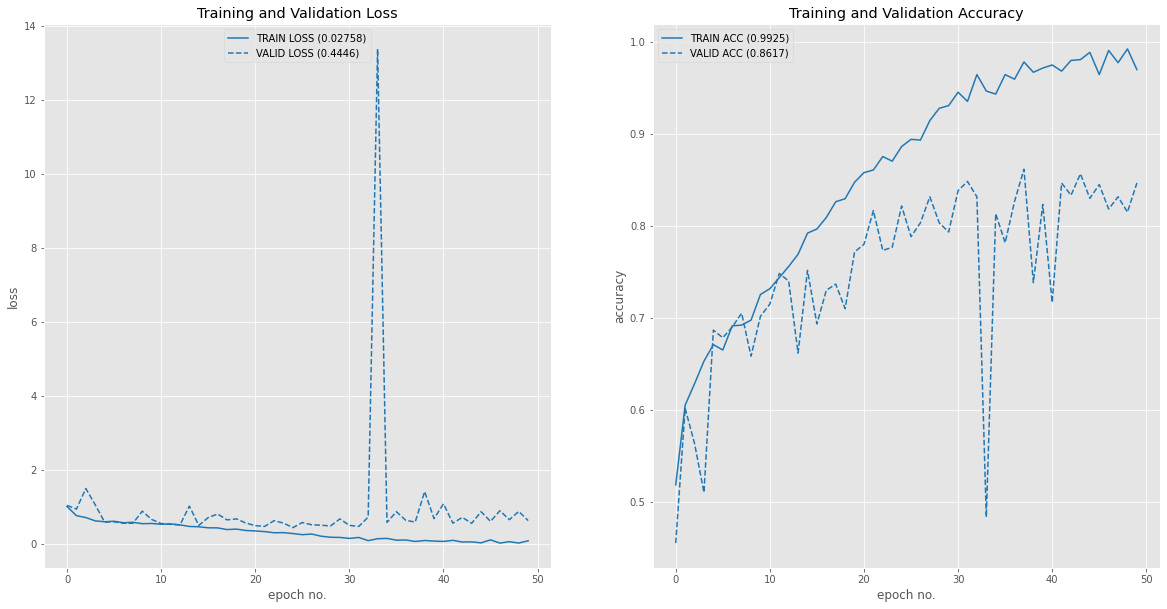

In [39]:
plot_loss_accuracy(train_loss=[train_loss], 
                   val_loss=[val_loss], 
                   train_acc=[train_acc], 
                   val_acc=[val_acc], 
                   colors=['blue'], 
                   loss_legend_loc='upper center', 
                   acc_legend_loc='upper left')

# <font style="color:blue">5. Sample Prediction</font>

Show some sample predictions.

## <font style="color:blue">5.1. Make Predictions</font>

In [25]:
def prediction(model, device, batch_input):
    
    # send model to cpu/cuda according to your system configuration
    model.to(device)
    
    # it is important to do model.eval() before prediction
    model.eval()

    data = batch_input.to(device)

    output = model(data)

    # Score to probability using softmax
    prob = F.softmax(output, dim=1)

    # get the max probability
    pred_prob = prob.data.max(dim=1)[0]
    
    # get the index of the max probability
    pred_index = prob.data.max(dim=1)[1]
    
    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

## <font style="color:blue">5.2. Get predictions on a batch</font>

In [23]:
def get_sample_prediction(model, data_root, mean, std):
    batch_size = 15

    if torch.cuda.is_available():
        device = "cuda"
        num_workers = 8
    else:
        device = "cpu"
        num_workers = 2
        
        
    
    # transformed data
    test_dataset_trans = datasets.ImageFolder(root=data_root, transform=image_common_transforms(mean, std))
    
    # original image dataset
    test_dataset = datasets.ImageFolder(root=data_root, transform=image_preprocess_transforms())
    
    data_len = test_dataset.__len__()
    
    interval = int(data_len/batch_size)
    
    imgs = []
    inputs = []
    targets = []
    for i in range(batch_size):
        index = i * interval
        trans_input, target = test_dataset_trans.__getitem__(index)
        img, _ = test_dataset.__getitem__(index)
        
        imgs.append(img)
        inputs.append(trans_input)
        targets.append(target)
        
    inputs = torch.stack(inputs)
        
    cls, prob = prediction(model, device, batch_input=inputs)
    
    plt.style.use('default')
    plt.rcParams["figure.figsize"] = (15, 9)
    fig = plt.figure()
    
    target_class = []
    for i, target in enumerate(targets):
        plt.subplot(3, 5, i+1)
        img = transforms.functional.to_pil_image(imgs[i])
        plt.imshow(img)
        plt.gca().set_title('P:{0}({1:.2}), T:{2}'.format(test_dataset.classes[cls[i]], 
                                                     prob[i], 
                                                     test_dataset.classes[targets[i]]))
        target_class.append(test_dataset.classes[targets[i]])
    fig.savefig('sample_prediction.png')
    plt.show()
    
    return cls, prob, target_class
        
    

## <font style="color:blue">5.3. Load Model and Run Inference</font>

mean: tensor([0.4610, 0.4347, 0.3897]), std: tensor([0.2400, 0.2356, 0.2306])


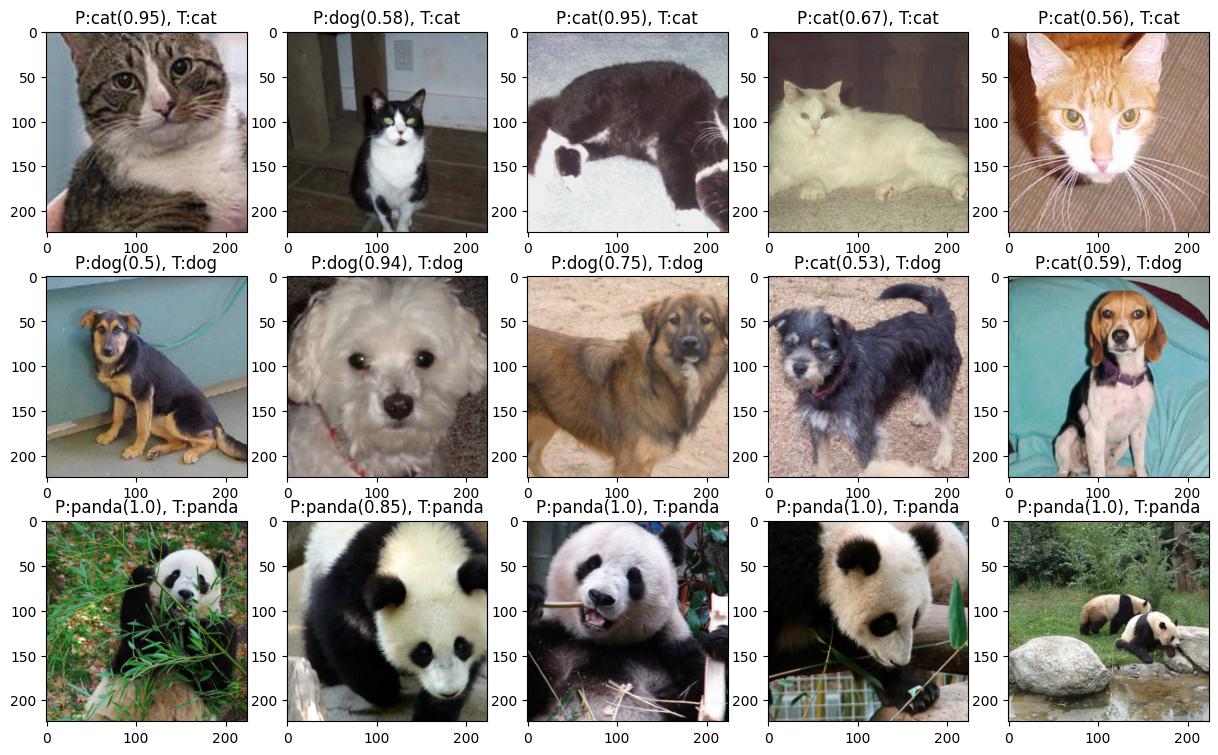

In [24]:
m = VggNet_bn()

m = load_model(m)

train_config = TrainingConfiguration()

test_data_path = os.path.join(train_config.data_root, 'validation')

train_data_path = os.path.join(train_config.data_root, 'training')

mean, std = get_mean_std(train_data_path)


cls, prob, target_class = get_sample_prediction(m, test_data_path, mean, std)